# Wet vs. Dry Manually Computed Output

## Setup

In [50]:
# Imports
import xarray as xr
from dask.distributed import Client
import dask
import numpy as np
from dask import delayed, compute
from scipy.ndimage import gaussian_filter

dask.config.set(**{'array.slicing.split_large_chunks': False})

In [51]:
# Initialize Dask client for better parallel processing
client = Client(threads_per_worker=1)


def load_data(init: str, keyword: str) -> xr.Dataset:
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.cftime_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
    )

    data = xr.open_mfdataset(
        f"/mnt/drive2/wof-runs/post-processed/{init}/wofs_{keyword.upper()}*.nc",
        concat_dim="time",
        combine="nested",
        parallel=True,
    )
    data["time"] = new_dates
    return data


ens = [load_data(i, "ens") for i in ["20Z", "21Z", "22Z", "23Z"]]
ens = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in ens]
ne = ens[0].ne


def load_wrfwof(init: str, var: str, ne: xr.DataArray) -> xr.Dataset:
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
        use_cftime=True,
    )

    def load_single_file(n):
        ds_in = xr.open_mfdataset(
            f"/mnt/drive2/wof-runs/{init}/{var}/wrfwof*{str(n).zfill(2)}",
            decode_times=False,
            combine="nested",
            concat_dim="Time",
            parallel=True,
            chunks="auto",  # Adjust the chunk size as needed
            engine="h5netcdf",
        )
        ds_in = ds_in.rename({"Time": "time", "south_north": "lat", "west_east": "lon"})
        ds_in["time"] = new_dates
        return ds_in.drop_vars("XTIME")

    ds_list = dask.compute(*[dask.delayed(load_single_file)(n) for n in range(1, 19)])
    ds_concat = xr.concat(ds_list, dim=ne)

    # Decode times after concatenation
    ds_concat = xr.decode_cf(ds_concat)
    return ds_concat


# z = [
#     load_wrfwof(i, "z_plev", ne).sel(pres=50000).squeeze()
#     for i in ["20Z", "21Z", "22Z", "23Z"]
# ]

In [3]:
# other functions
def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    copy = da.copy()  # Make a copy of the DataArray
    copy.values = gaussian_filter(
        da.values, sigma=sigma, axes=axes
    )  # Smooth the values
    return copy  # Return the smoothed DataArray

@delayed
def bootstrap_iteration_mean(da, sample_size):
    """Single iteration of bootstrapping"""
    # Get run indices
    run_indices = np.arange(da.run.size)
    
    # Sample without replacement
    sample1_indices = np.random.choice(run_indices, sample_size, replace=False)
    sample2_indices = np.random.choice(run_indices, sample_size, replace=False)

    # Select corresponding runs
    sample1 = da.isel(run=sample1_indices)
    sample2 = da.isel(run=sample2_indices)

    # Compute PMM for each sample
    mean1 = sample1.mean(dim="run")  # Compute mean
    mean2 = sample2.mean(dim="run")  # Compute mean

    # Compute difference of PMMs
    diff = mean1 - mean2
    return diff


def bootstrap_mean_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of means"""
    tasks = [bootstrap_iteration_mean(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")

In [53]:
## Create ensembles
# Set desired latitude and longitude
nyc_lat, nyc_lon = 40.7826, -73.9656

# Isolate xlat and xlon for ease of use
lat = ens[0].xlat.isel(time=0)
lon = ens[0].xlon.isel(time=0)

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY", "NX"])
ny_ind, nx_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])
# We are going to sort by the area averaged precip
rain_1to2Z = [
    e.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(dim="time")
    for e in ens
]

# Calculate the area average hourly precip for a box around Central Park
aoi_48km = [
    r.isel(lat=slice(ny_ind - 8, ny_ind + 8), lon=slice(nx_ind - 8, nx_ind + 8))
    for r in rain_1to2Z
]
avg_48km = [a.mean(dim=["lat", "lon"]) for a in aoi_48km]

# Get the indices of the wettest and driest ensemble members
ne_wet = [a.ne.where(a > a.quantile(0.75, dim="ne")).dropna(dim="ne") for a in avg_48km]
ne_dry = [a.ne.where(a < a.quantile(0.25, dim="ne")).dropna(dim="ne") for a in avg_48km]

# Make a new init dimension to concatenate the DataArrays
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init")
init = init.assign_coords({"init": init})

In [54]:
client.shutdown()

In [31]:
z500_all = smooth(
    xr.concat(
        [
            i.z.chunk({"ne": -1,"lat": -1, "lon": -1, "time": 1})
            for i in z
        ],
        dim=init,
    ).stack(run=("ne", "init")),
    sigma=1,
)

In [34]:
z500_all.to_netcdf("/mnt/drive2/processed_results/z500_all.nc")

NotImplementedError: variable 'run' is a MultiIndex, which cannot yet be serialized. Instead, either use reset_index() to convert MultiIndex levels into coordinate variables instead or use https://cf-xarray.readthedocs.io/en/latest/coding.html.

In [35]:
z500_all.reset_index("run").to_netcdf("/mnt/drive2/processed_results/z500_all.nc")

In [49]:
z500_all.XLONG.dims

('time', 'lat', 'lon', 'run')

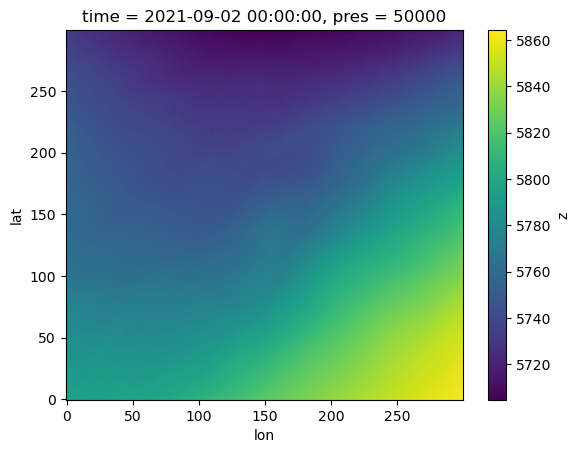

In [22]:
z500_all.sel(time="2021-09-02 00:00:00").squeeze().mean(dim="run").plot()

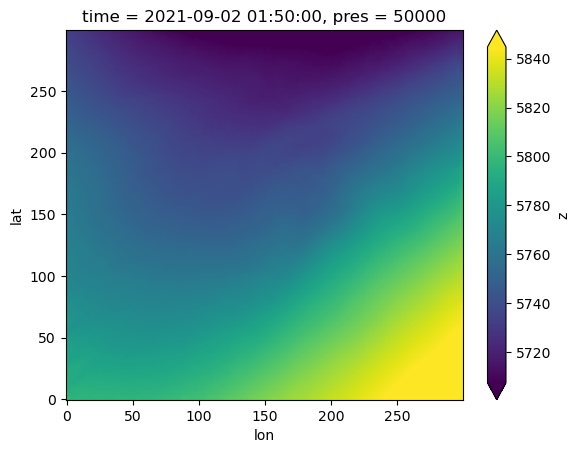

In [8]:
z500_all.isel(time=70).mean(dim="run").plot(robust=True)

In [15]:
foo = xr.open_dataset("/mnt/drive2/wof-runs/20Z/z_plev/wrfwof_d01_2021-09-01_20:00:00.01")
bar = xr.open_dataset("/mnt/drive2/wof-runs/20Z/z_plev/wrfwof_d01_2021-09-01_20:05:00.01")

In [23]:
test = xr.concat([foo,bar],dim="Time")

In [25]:
bar.XTIME.values

array([5.], dtype=float32)